In [10]:
import torch 
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt 

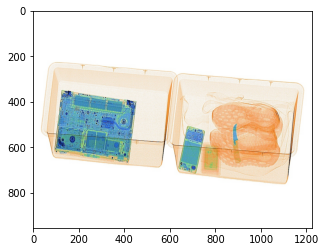

In [2]:
# Image
img = Image.open('..\\images\\0.jpg')
plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.show()

In [3]:
# !pip install torchvision==0.10.1
# !pip install torch==1.9.1

In [4]:
import cv2
import torch
import numpy as np
import sys
sys.path.append('.\\yolov5')

from utils.datasets import letterbox
from utils.general import non_max_suppression, scale_coords


class YoloPredictor:
    def __init__(self, model_path='./yolo_models/yolo_field_detector.pt', iou_t=0.5, conf_t=0.4,  device='cpu'):
        self.model = self.load_yolo(model_path, device=device)
        self.device=device
        self.IOU_TRES = iou_t
        self.CONF_TRES = conf_t
    
    def load_yolo(self, model_path, device='cpu'):
        
        ckpt = torch.load(model_path, map_location='cpu')
        model = ckpt['model'].float().fuse().eval()
        model.to(device)
        return model

    def yolo_preprocess(self, image, size=(640, 640)):
        img = image.copy()
        img_res = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_res = letterbox(img_res, new_shape=size)[0]

        img_res = img_res.transpose(2, 0, 1)

        img_tensor = torch.from_numpy(img_res)
        img_tensor = img_tensor.float()
        img_tensor /= 255.0

        img_tensor = img_tensor.unsqueeze(0)
        return img_tensor

    def yolo_postprocess(self, pred, tensor_shape, orig_shape, bbox):
        pred = non_max_suppression(pred, self.CONF_TRES, self.IOU_TRES)
        
        new_preds = []
        for i, det in enumerate(pred):
            if det is not None and len(det):
                det[:, :4] = scale_coords(tensor_shape[2:], det[:, :4], orig_shape).round()
                det[:, :4] += torch.tensor([bbox[0], bbox[1], bbox[0], bbox[1]])
                for *xyxy, conf, label in reversed(det):
                    new_preds.append({'conf': float(conf.numpy()),
                                      'label': int(label.numpy()),
                                      'x1': int(xyxy[0]),
                                      'y1': int(xyxy[1]),
                                      'x2': int(xyxy[2]),
                                      'y2': int(xyxy[3])})

            return new_preds

    def find_fields(self, model, image, device='cpu'):
        img = image.copy()
        img_h, img_w = img.shape[:2]
        bbox = [0, 0, img_w, img_h]
        with torch.no_grad():
            y_img = self.yolo_preprocess(img).to(device)
            predict = self.model(y_img)[0]
            y_preds = self.yolo_postprocess(predict.detach().cpu(), y_img.shape, (img_h, img_w), bbox)

        return y_preds
    
    def predict(self, image):
        return self.find_fields(self.model, image, self.device)

In [5]:
model = YoloPredictor('weights\\best.pt')

Fusing layers... 
Model summary: 290 layers, 20869098 parameters, 0 gradients, 48.0 GFLOPs


In [6]:
image = np.array(img)
predict = model.predict(image)

In [7]:
predict

[{'conf': 0.6311455965042114,
  'label': 0,
  'x1': 857,
  'y1': 473,
  'x2': 932,
  'y2': 668}]

C:\Users\66615\AppData\Local\Temp\ipykernel_3296\1087749148.py:5: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


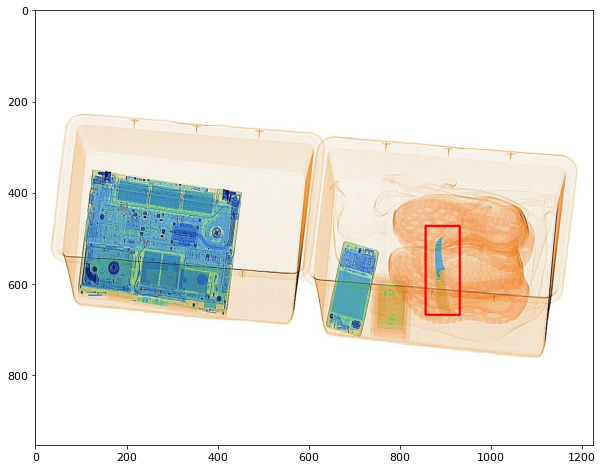

In [9]:
output = np.array(img).copy()
cv2.rectangle(output, (predict[0]['x1'], predict[0]['y1']), (predict[0]['x2'], predict[0]['y2']), (255, 0, 0), 3)
plt.figure(figsize=(10, 10))
plt.imshow(output)
plt.show()